# Information about paper and code

## Code Authors
Erce Guder - Adnan Harun Dogan

## Paper Name:
FEW-SHOT CROSS-DOMAIN IMAGE GENERATION VIA INFERENCE-TIME LATENT-CODE LEARNING (ICLR2023) https://openreview.net/pdf?id=sCYXJr3QJM8

## Paper Summary
_"Can a GAN trained on a single large-scale source dataset be adapted to multiple target domains containing very few examples without re-training the pre-trained source generator?"_

The goal of the paper is to learn a latent-generation network (during inference stage) that maps random Gaussian noise to latents in the W space (style) of a pre-trained StyleGAN2 **without updating the generator** (we don't want to overfit / forget rich prior knowledge) such that the generator can sample from the target domain. There are two loss functions used to ensure that the samples belong to target domain:

  - Adversarial loss
  - Style Loss (Content Loss / VGG-Loss)

## Datasets: 
We shall take StyleGAN2 checkpoints trained on:
* *Flickr Faces HQ (FFHQ)* dataset. Our target domains will be

  - FFHQ-Babies,
  - FFHQ-Sunglasses, 
  - Face sketches, 
  - Emoji faces from bitmoji.com, 
  - Portrait paintings from the artistic faces dataset.

* *LSUN Church* as a source domain and adapt to
  - the haunted houses, 
  - Van Goh’s house paintings.

# Hyper-parameters of the model

As the authors of this paper also did, we took checkpoints that were presented by StyleGAN2 repositories. So, we are not sure if we should present the hyper-parameters of StyleGAN2.

Nevertheless, the hyper-parameters of StyleGAN2:
 - Output size of 256x256 pixels (generator & discriminator)
 - W dimension of 512 (generator)
 - Number of layers mapping Z to W: 8 (generator)

The latent generation network is decided to be (mentioned in the paper):
 - 3-Layer MLP with
 - ReLU activations

Rest of the hyper-parameters are as follows:
 - Learning rate for discriminator & latent generation network: 5e-4
 - Optimizer for discriminator & latent generation network:
     - Adam with betas (0.0, 0.99)
 - Batch size: 4

In [1]:
%load_ext autoreload
%autoreload 2

# Training and saving a model. 


In [2]:
from model import Generator, Discriminator
from latent_learner import LatentLearner
from dataset import Dataset
from tqdm import tqdm
import loss
import random

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import gc
import os

/home/ceng796/miniconda3/envs/796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch import nn
from torch.nn import functional as F

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


def get_style_model_and_loss(cnn, normalization_mean, normalization_std, target_img, style_layers, device):

    style_losses = []
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in style_layers:
            # add style loss:
            target_feature = model(target_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses

In [4]:
@torch.no_grad()
def save_samples(x_1, x_2, generator, latent_learner, iter_):
    os.makedirs("samples", exist_ok=True)
    
    generator.eval()
    latent_learner.eval()
    
    for i in range(len(x_1)):
        noise_1 = torch.unsqueeze(x_1[i], 0)
        noise_2 = torch.unsqueeze(x_2[i], 0)

        noise = torch.cat([noise_1, noise_2], axis=-1)
        # Map to latent
        w = latent_learner(noise)

        # Pass through Generator
        samples, _ = generator([w])

        # Save for later examination
        torchvision.utils.save_image(
            samples.detach(),
            f"samples/samples_{iter_}_{i}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )

In [5]:
def disable_grad(model):
    for _, param in model.named_parameters():
        param.requires_grad = False

def train(device, max_iters=150):
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
    discriminator = Discriminator(size=256).to(device)
    latent_learner = LatentLearner().to(device)

    vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()

    # No need for gradients on the parameters of these
    disable_grad(generator)
    disable_grad(vgg)

    # Take sub-networks from the vgg, later used to compute style loss
#    subnetworks = loss.subnetworks(vgg, max_layers=5)

    # Garbage collection
#    del vgg
#    gc.collect()
#    torch.cuda.empty_cache()

    # Load checkpoint and weights
    ckpt = torch.load("550000.pt")

    generator.load_state_dict(ckpt["g_ema"], strict=False)
    generator.eval()

    discriminator.load_state_dict(ckpt["d"])

    # Initialize optimizers (no optimizer for generator :)
    disc_opt = torch.optim.Adam(
        discriminator.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )
    latent_learner_opt = torch.optim.Adam(
        latent_learner.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )

    # Simple transformation pipeline
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Create simple dataset & loader
    x_1 = torch.randn(10, 512, device=device)
    x_2 = torch.randn(10, 512, device=device)

    dataset = Dataset(path="./babies", device=device, transforms=transforms)

    bar = tqdm(range(max_iters))

    # 150 iterations
    for idx in bar:
        i = np.random.choice(10, size=4, replace=False)
        imgs = dataset[i]
#        noise = x[i]

        idx_1 = np.random.choice(10, size=imgs.shape[0], replace=False)
        idx_2 = np.random.choice(10, size=imgs.shape[0], replace=False)

        x = torch.cat([x_1[idx_1], x_2[idx_2]], axis=-1)

        ##### Adversarial Loss ##### 
        # first forward pass
        w = latent_learner(x)
        samples, _ = generator([w], input_is_latent=True)

        real_scores = discriminator(imgs)
        fake_scores = discriminator(samples)

#        print(f"fake_scores: {fake_scores.view(-1).cpu()}, real_scores: {real_scores.view(-1).cpu()}")

        d_loss = loss.d_logistic_loss(real_scores, fake_scores)

        # optimization step on discriminator
        disc_opt.zero_grad()
        d_loss.backward()
        disc_opt.step()

        # second forward pass (needed)
        w = latent_learner(x)
        samples, _ = generator([w], input_is_latent=True)

        fake_scores = discriminator(samples)

        g_loss = 5 * (1 - idx/max_iters) * loss.g_nonsaturating_loss(fake_scores)

        # optimization step on latent learner
        latent_learner_opt.zero_grad()
        g_loss.backward()
        latent_learner_opt.step()

        ##### Style Loss #####
        idx_1 = np.random.choice(10, size=5, replace=False)

        for i in idx_1:
            img_idx = np.random.randint(0, 10)
            img = torch.unsqueeze(dataset[img_idx], 0)

            noise_1 = torch.unsqueeze(x_1[i], 0)
            noise_2 = torch.unsqueeze(x_2[img_idx], 0)

            x = torch.cat([noise_1, noise_2], axis=-1)

            w = latent_learner(x)
            sample, _ = generator([w], input_is_latent=True)

            #style_loss = 50 * loss.style_loss(subnetworks, img, sample)
            model, style_losses = get_style_model_and_loss(vgg, cnn_normalization_mean, cnn_normalization_std,
                                                           img, style_layers_default, device)
            disable_grad(model)
            style_loss = 0
            model(sample)
            for sl in style_losses:
                style_loss += sl.loss
            style_loss *= 50

            # optimization step on latent learner
            latent_learner_opt.zero_grad()
            style_loss.backward()
            latent_learner_opt.step()

        bar.set_description(f"d_loss: {d_loss.cpu():.2f}, g_loss: {g_loss.cpu():.2f}, style_loss: {style_loss:.2f}")

        if (idx+1) % 50 == 0:
            save_samples(x_1, x_2, generator, latent_learner, idx+1)

    return torch.cat([x_1, x_2], axis=-1), latent_learner, generator

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
noise, latent_learner, generator = train(device, max_iters=51)

  0%|                                                                                            | 0/51 [00:00<?, ?it/s]/home/ceng796/inference-time-latent-code-learning/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
d_loss: 0.03, g_loss: 0.51, style_loss: 1.32: 100%|█████████████████████████████████████| 51/51 [00:45<00:00,  1.11it/s]


In [8]:
os.makedirs("ckpts", exist_ok=True)

torch.save(noise, "ckpts/noise.pt")
torch.save(latent_learner.state_dict(), "ckpts/latent_learner.pt")
torch.save(generator.state_dict(), "ckpts/generator.pt")

# Loading a pre-trained model and computing qualitative samples/outputs from that model

In [9]:
generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
generator.load_state_dict(torch.load("ckpts/generator.pt"))
generator.eval()

latent_learner = LatentLearner().to(device)
latent_learner.load_state_dict(torch.load("ckpts/latent_learner.pt"))

noise = torch.load("ckpts/noise.pt")

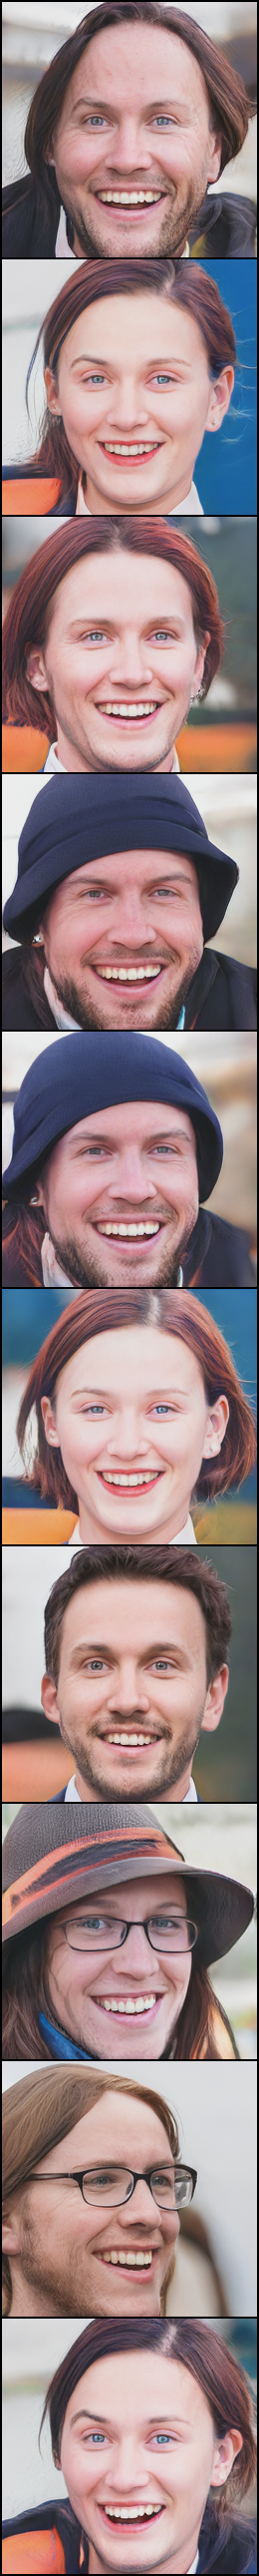

In [10]:
with torch.no_grad():
    # Map to latent
    w = latent_learner(noise)

    # Pass through Generator
    samples, _ = generator([w])

    # Save for later examination
    torchvision.utils.save_image(
        samples.detach(),
        "samples.png",
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )

    from PIL import Image

    display(Image.open("samples.png"))

**It is obvious that the generator collapsed, and the results are not baby images.**

We believe that this is a  direct consequence of us not being able to fully understand the algorithm.